# Проект: классификация

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [189]:
df = pd.read_csv('bank_fin.csv', sep = ';')

Посчитаем количество пропусков методом isnull()

In [190]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Фактически пропуски есть только в признаке 'balance'. Нужно еще проверить на неявные пропуски.

### Задание 2

In [191]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

В признаке 'job' есть пропуски в виде строки 'unknown', при вызове датасета можно заметить, что строка 'unknown' есть во многих признаках.

### Задание 3

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


При вызове метода info() определяем, что признак 'balance' имеет тип object.

С помощью методов replace() и astype() преобразовываем столбец 'balance'.

In [193]:
for balance in df['balance']:
    if type(balance) is not float:
        clean = balance \
            .split(',')[0] \
            .replace('$', '') \
            .replace(' ', '')
        
        df = df.replace({'balance':{balance:clean}})

# проверяем, что все лишнее удалилось        
df['balance']

0        2343
1          45
2        1270
3        2476
4         184
         ... 
11157       1
11158     733
11159      29
11160       0
11161       0
Name: balance, Length: 11162, dtype: object

In [194]:
df['balance'] = df['balance'].astype('float')

### Задание 4

In [195]:
# Выводим среднее значение
print(round(df['balance'].mean(), 3))

1529.129


In [196]:
df['balance'] = df['balance'].fillna(df['balance'].median())
print(round(df['balance'].mean(), 3))

1526.936


Видим, что при заполнении пропусков, среднее значение признака поменялось.

### Задание 5

In [197]:
# Находим наиболее часто встречающееся значение в признаке 'job' и 'education и заменяем пропуски в этих признаках на них
print(df['job'].value_counts())
print('-----------------------')
print(df['education'].value_counts())

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64
-----------------------
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64


In [198]:
df.loc[df.job == 'unknown', 'job'] = 'management'
df.loc[df.education == 'unknown', 'education'] = 'secondary'

In [199]:
# Выводим средний баланс для клиентов с самой популярной работой и 
# самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование).
print(round(df[(df.job=='management') & (df.education=='secondary')]['balance'].mean(), 3))

1598.883


### Задание 6

Использую метод np.percentile() из библиотеки numpy для поиска значений квартилей. 
Для верхнего квартиля вам нужен аргумент 75, а для нижнего — 25.
Еще построила диаграмму с усами для случая с выбросами и без.

In [200]:
Percentile = np.percentile(df['balance'],[0,25,50,75,100])
IQR = Percentile[3] - Percentile[1] 
UpLimit = Percentile[3]+IQR*1.5 
DownLimit = Percentile[1]-IQR*1.5
print('UpLimit =', UpLimit, ';' , 'DownLimit =', DownLimit, sep = ' ')

UpLimit = 4063.0 ; DownLimit = -2241.0


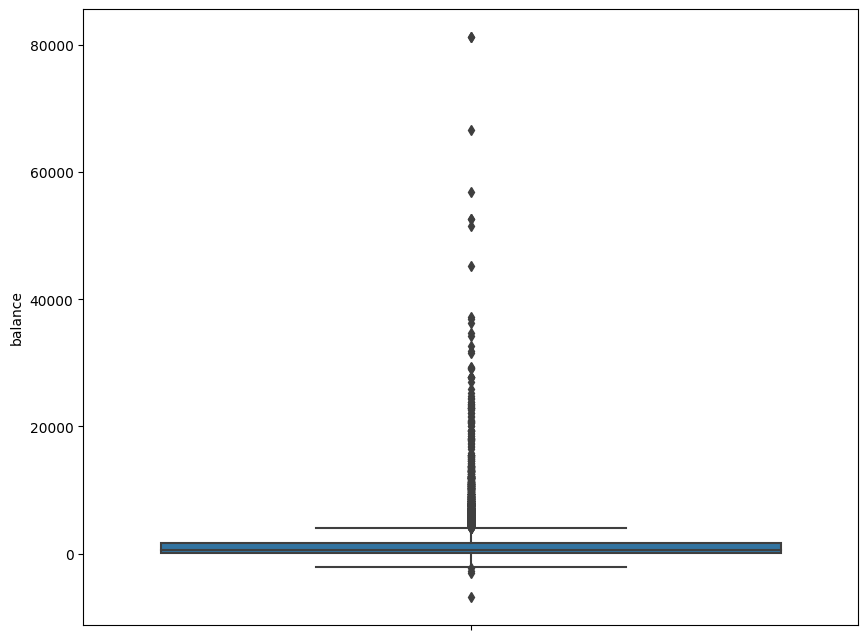

In [201]:
f,ax=plt.subplots(figsize=(10,8)), sns.boxplot(y='balance',data=df) 
plt.show()

In [202]:
# Запрлняем пустыми значениями выбросы
df.loc[df['balance'] < DownLimit, 'balance'] = np.nan
df.loc[df['balance'] > UpLimit, 'balance'] = np.nan

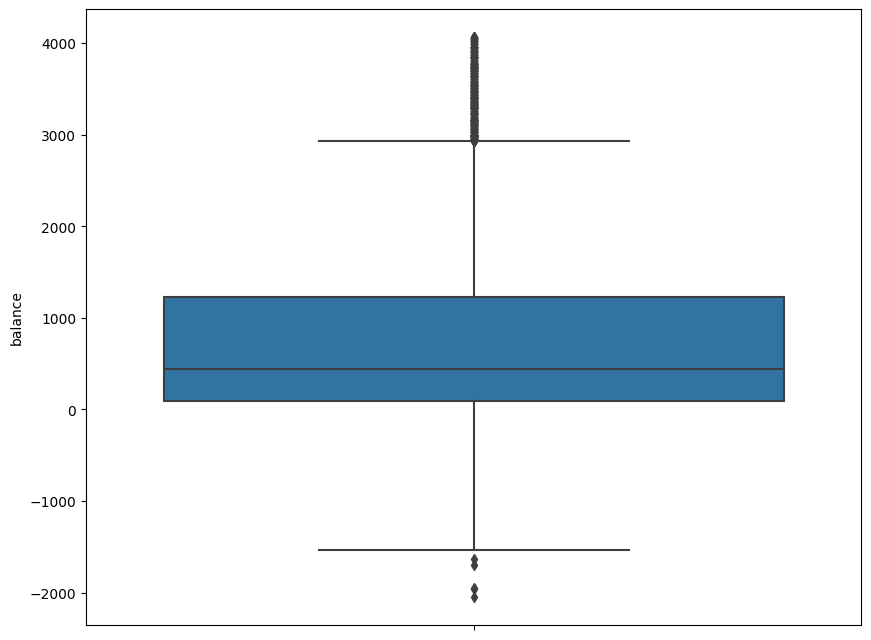

In [203]:
f,ax=plt.subplots(figsize=(10,8)), sns.boxplot(y='balance',data=df)
plt.show()

Я использовала для сравнения диаграммы, чтобы понять, сработал ли метод.

In [204]:
# Удалила все пустые значения
df.dropna(subset=['balance'], inplace=True)

In [205]:
# С помощью метода info() определяем размер новой выборки
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


## Часть 2:  Разведывательный анализ

### Задание 1

In [206]:
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

Можно отметить, что большинство клиентов не хотят открывать депозит в банке. Можно посмотреть на процентное соотношение.

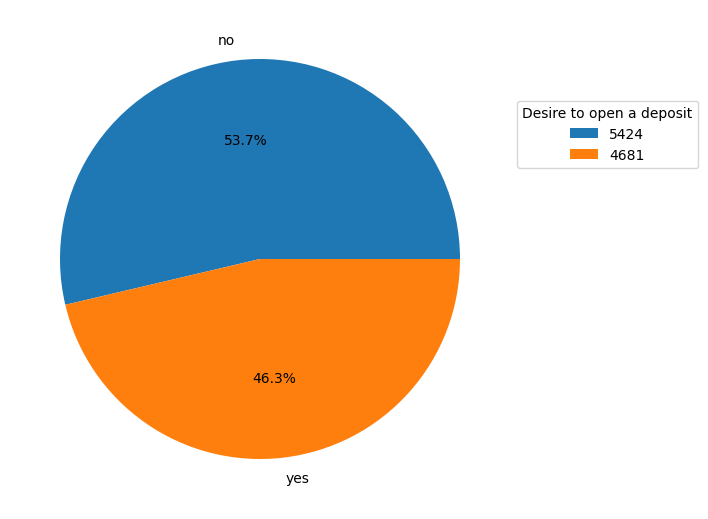

In [207]:
ratio_clients = df['deposit'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    ratio_clients,
    labels=ratio_clients.index,
    autopct='%.1f%%'    
)
axes.legend(ratio_clients,
            title = 'Desire to open a deposit',
            loc = 'center left',
            bbox_to_anchor=(1, 0, 0.5, 1.5))


В процентном соотношении можем видеть, что 46,3 % хотят открыть депозит, большинство клиентов отказывается. В принципе, данные достаточно сбалансированные.

### Задание 2

In [208]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


По описательным данным для каждого признака можно сказать, что максимальный возраст клиента банка = 95 лет. А минимальная продолжительность разговора 2 секунды.

### Задание 3

In [209]:
df['month'].value_counts().count()

12

Месяцев, в которых проводилась маркетинговая кампания, всего 12. Ниже представлен график распределения "удач" в маркентиговых кампаний по месяцам.

Text(0, 0.5, 'Number of success')

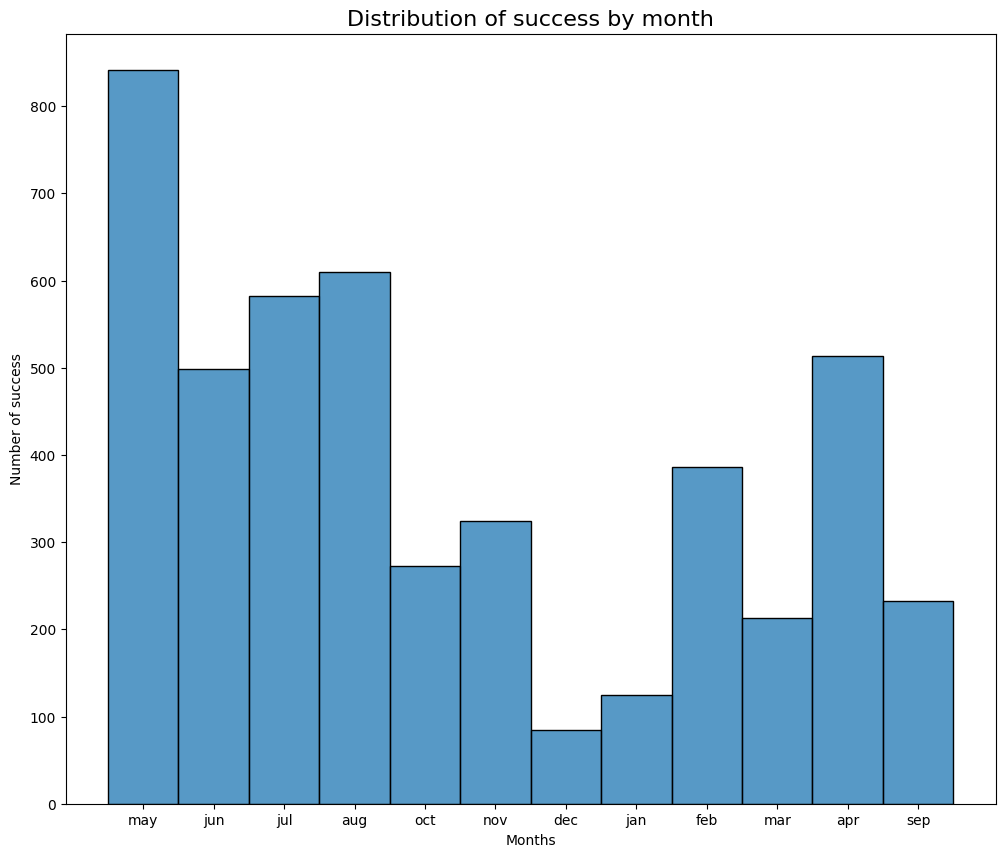

In [210]:
fig, axes = plt.subplots(figsize=(12, 10))

histplot1 = sns.histplot(
    data=df[df.deposit=='yes'], 
    x='month', 
    bins=30
)
histplot1.set_title('Distribution of success by month', fontsize=16)
histplot1.set_xlabel('Months')
histplot1.set_ylabel('Number of success')

In [211]:
df['job'].value_counts().count()

11

Представлено всего 11 сфер занятости среди клиентов банка. Ниже представлен график распределения числа клиентов в зависимости от сферы занятости.

Text(0, 0.5, 'Number of clients')

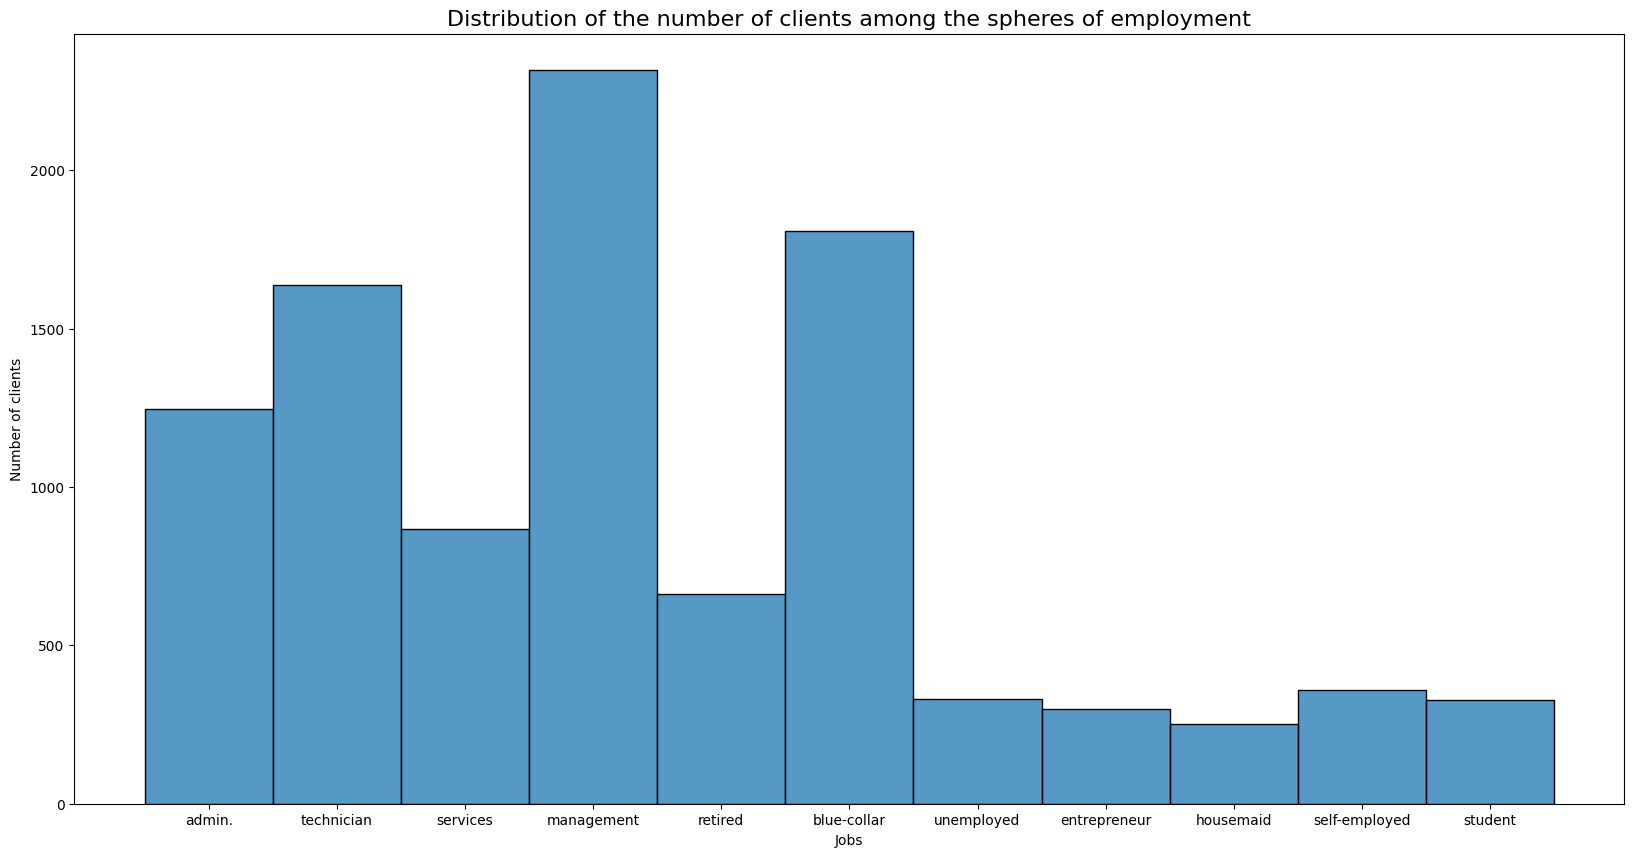

In [212]:
fig, axes = plt.subplots(figsize=(20, 10))

histplot1 = sns.histplot(
    data=df, 
    x='job', 
    bins=30
)
histplot1.set_title('Distribution of the number of clients among the spheres of employment', fontsize=16)
histplot1.set_xlabel('Jobs')
histplot1.set_ylabel('Number of clients')

### Задание 4

Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач. будем считать успехом, если значение будет больше 1.

In [213]:
result = df[df.deposit=='yes']['poutcome'].value_counts() / df[df.deposit=='no']['poutcome'].value_counts()
print(result)

failure     0.973310
other       1.226852
success    10.250000
unknown     0.659360
Name: poutcome, dtype: float64


<AxesSubplot:xlabel='poutcome'>

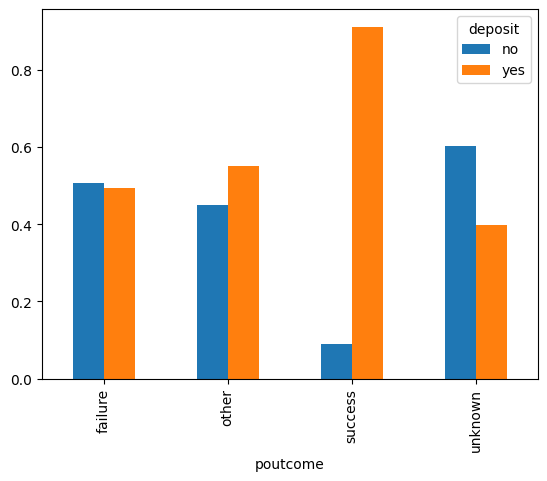

In [214]:
res = df.groupby("poutcome")['deposit'].value_counts(normalize=True).unstack()
res.plot(kind='bar')

Самое большое значение у статуса 'success'.

### Задание 5

Рассчитаем, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании.

In [215]:
months = df['month'].unique()
for month in months:
    rate = round((df[(df.deposit=='no') & (df.month == month)]['month'].count() / df[df.month == month]['month'].count()), 4)
    print(rate, month, sep='    ')

0.6786    may
0.5489    jun
0.5896    jul
0.5596    aug
0.1851    oct
0.5846    nov
0.0968    dec
0.6082    jan
0.4556    feb
0.1013    mar
0.3819    apr
0.1655    sep


Самый большой процент отказов в мае. С помощью диаграммы также можно посмотреть распределение по месяцам и убедиться в том, что самый большой процент отказов в мае.

Text(0, 0.5, 'Number of failures')

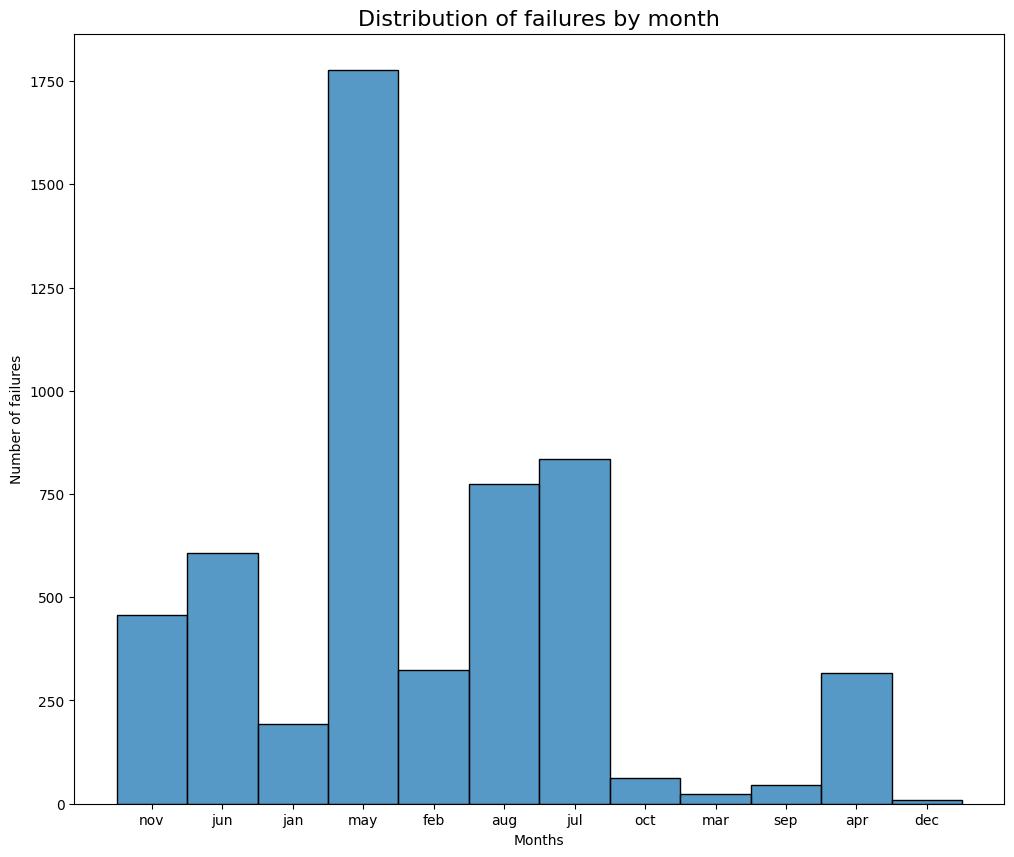

In [216]:
fig, axes = plt.subplots(figsize=(12, 10))

histplot1 = sns.histplot(
    data=df[df.deposit=='no'], 
    x='month', 
    bins=30
)
histplot1.set_title('Distribution of failures by month', fontsize=16)
histplot1.set_xlabel('Months')
histplot1.set_ylabel('Number of failures')

### Задание 6

Посмотрим на распределение возрастов клиентов. Для начала построим диаграмму рассеяния, в качестве метки выберем признак 'deposit'.

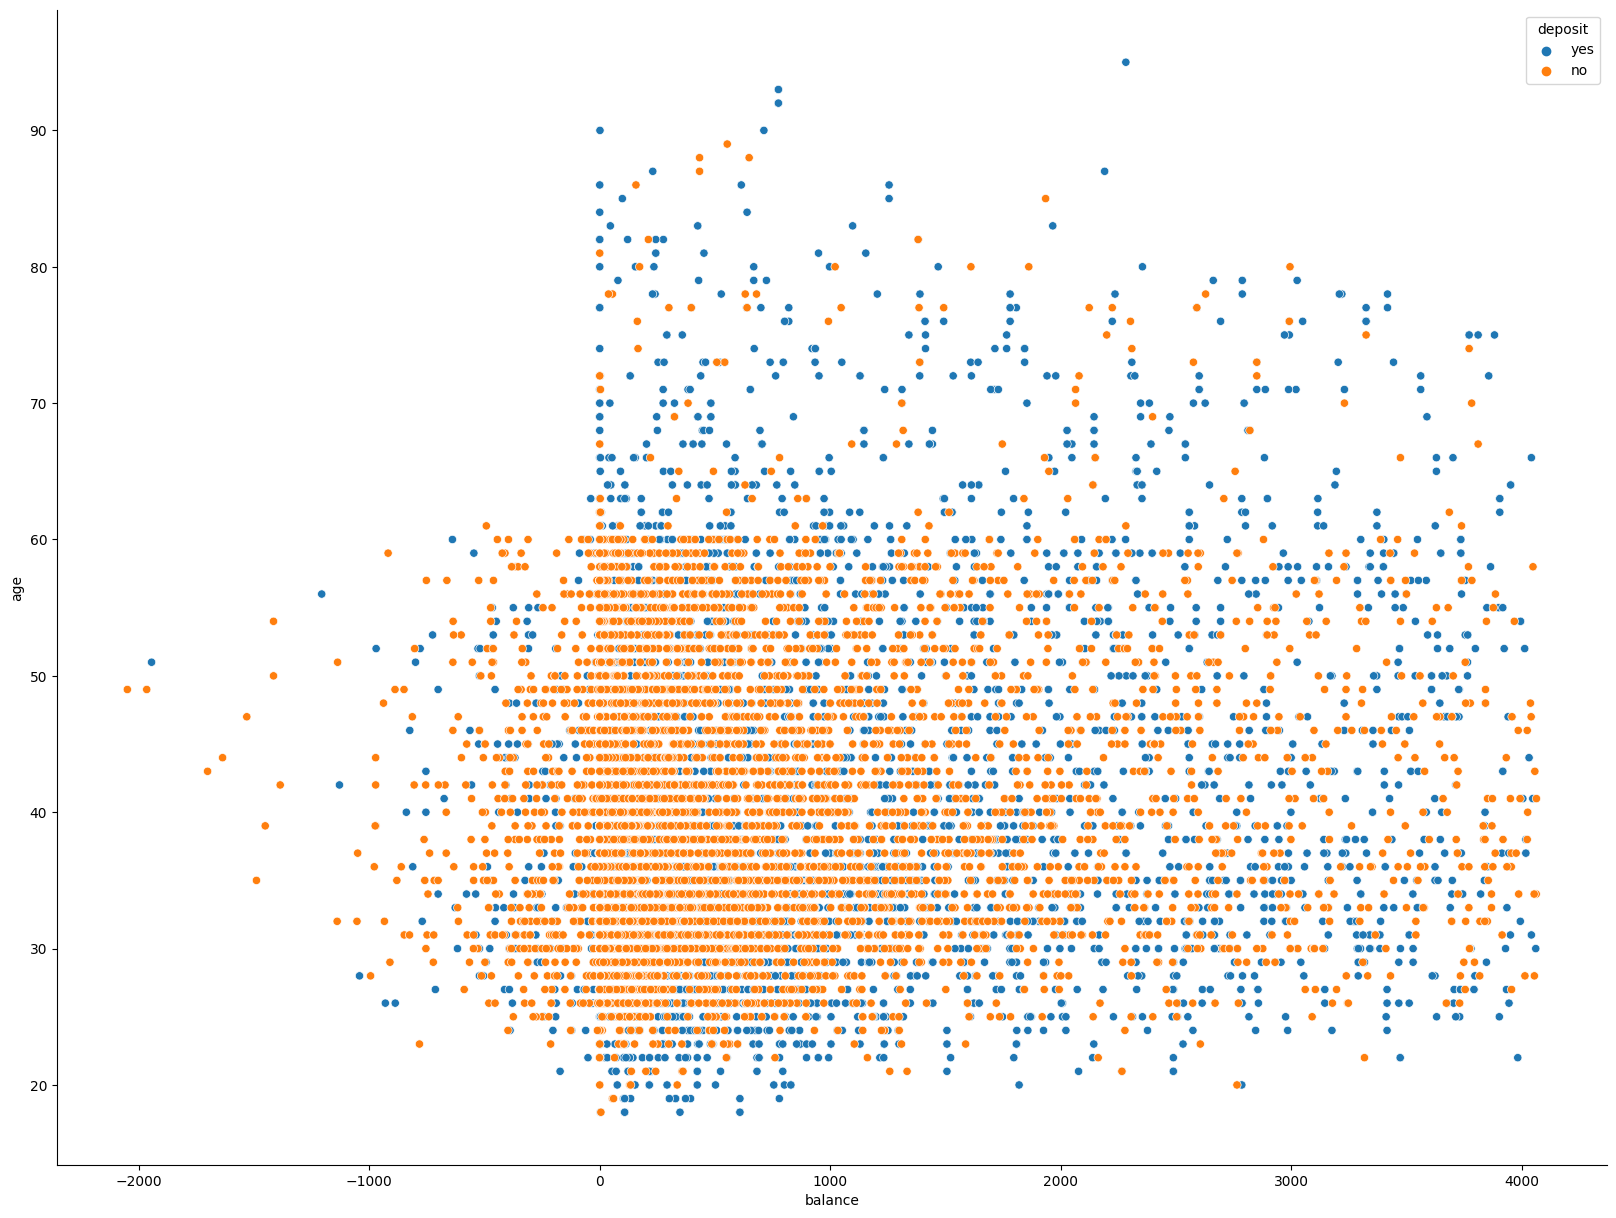

In [217]:
fig, axes = plt.subplots(figsize=(20, 15))

sns.scatterplot(
    x='balance',
    y='age',
    data=df,    
    hue='deposit'
)

sns.despine() 

По данному графику видно, что после 60 лет и до 30 лет клиенты склонны скорее открывать депозит, чем нет. Можно это проверить.

In [218]:
# Напишем функцию, которая преобразует признак возраста в возрастные группы.

def age_duration(age):
    if age < 30:
        age = '<30'
    elif 30 <= age < 40:
        age = '30-40'
    elif 40 <= age < 50:
        age = '40-50'
    elif 50 <= age < 60:
        age = '50-60'
    elif age >= 60:
        age = '60+'
    return age

df['age'] = df['age'].apply(age_duration)

Text(0.5, 1.0, 'Customer ratio')

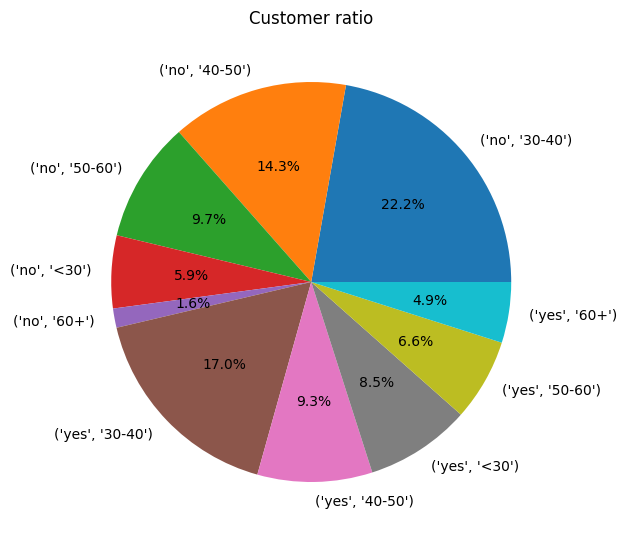

In [220]:
ratio_clients = df.groupby(['deposit'])['age'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    ratio_clients,
    labels=ratio_clients.index,
    autopct='%.1f%%'    
)

axes.set_title('Customer ratio')

Данная диаграмма подтверждает предположение, выдвинутое выше.

### Задание 7

Text(0.5, 1.0, 'Distribution of deposit depending on marital status')

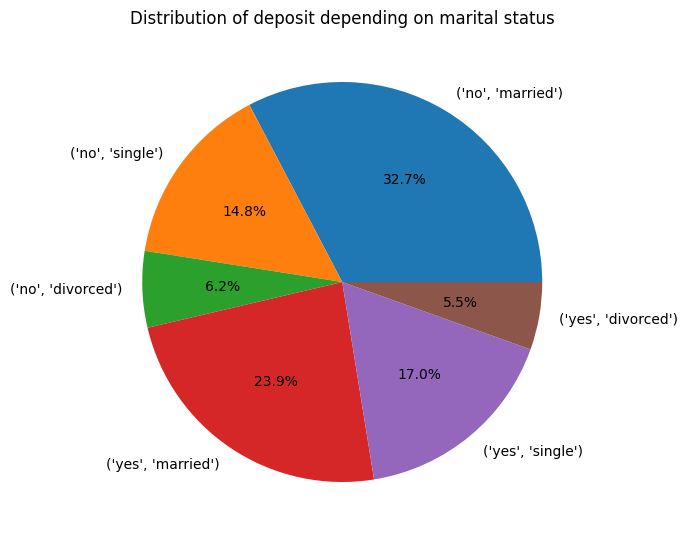

In [133]:
ratio_marital = df.groupby(['deposit'])['marital'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    ratio_marital,
    labels=ratio_marital.index,
    autopct='%.1f%%'    
)

axes.set_title('Distribution of deposit depending on marital status')

<AxesSubplot:xlabel='count', ylabel='marital'>

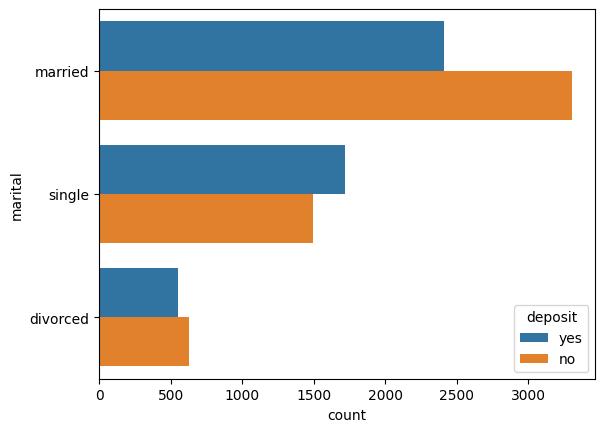

In [221]:
sns.countplot(y='marital', hue='deposit', data=df)

По данной диаграмме видно, что единственный тип клиентов, большая часть из которых предпочитают открывать депозит, - это 'single'.

Text(0.5, 1.0, 'Distribution of deposit openings from education')

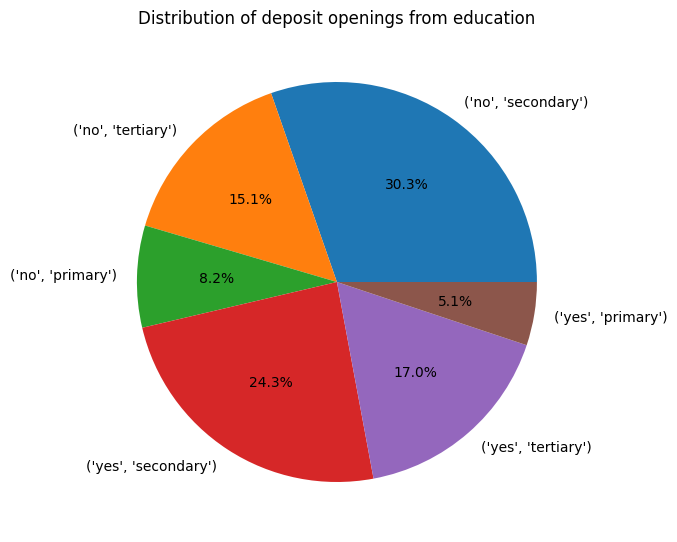

In [137]:
ratio_education = df.groupby(['deposit'])['education'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    ratio_education,
    labels=ratio_education.index,
    autopct='%.1f%%'
)

axes.set_title('Distribution of deposit openings from education')

<AxesSubplot:xlabel='count', ylabel='education'>

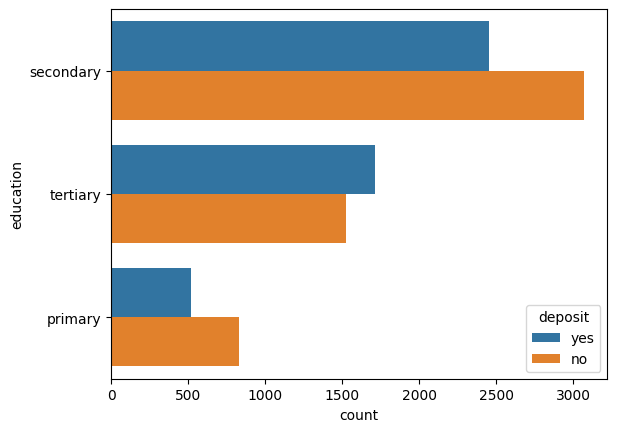

In [222]:
sns.countplot(y='education', hue='deposit', data=df)

Выше построена диаграмма открывших и неоткрывших депозит в зависимости от образования, по ней видно, что клиенты с  признаком 'tertiary' больше предпозитают открывать депозит, нежели нет.

Text(0.5, 1.0, 'Distribution of customer from job')

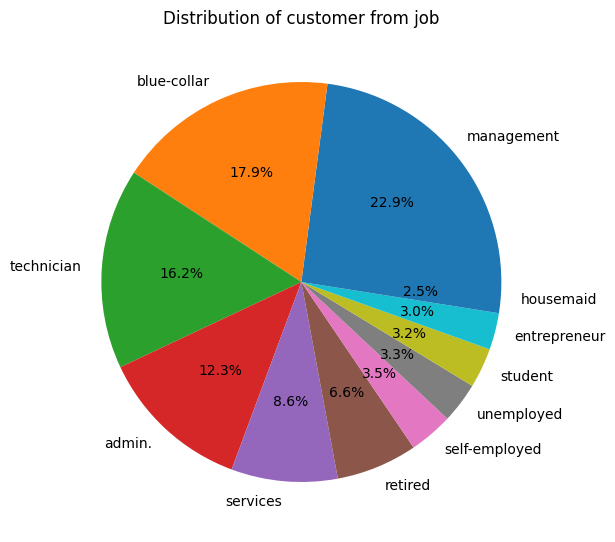

In [138]:
ratio_job = df['job'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    ratio_job,
    labels=ratio_job.index,
    autopct='%.1f%%'
)

axes.set_title('Distribution of customer from job')

По диаграмме видно, что среди клиентов большую часть занимают менеджеры.

<AxesSubplot:xlabel='count', ylabel='job'>

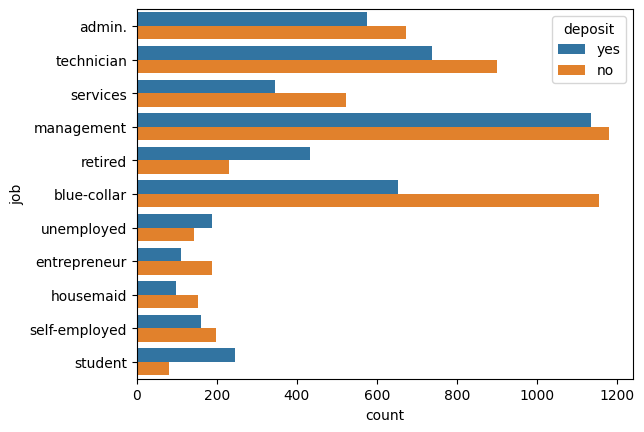

In [223]:
sns.countplot(y='job', hue='deposit', data=df)

В целом, можно сделать вывод, что для всех профессий характерно не открывать депозит, нежели открывать. Среди всех профессий предпочитают открывать депозит всего три категории: 'retired', 'unemployed', 'student'.

### Задание 8

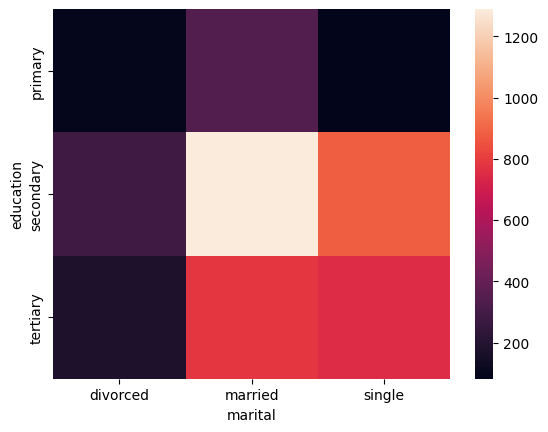

In [224]:
deposit_yes = df[df.deposit=='yes']
table = pd.pivot_table(deposit_yes, index='education', columns='marital', values='deposit', aggfunc='count')
heatmap = sns.heatmap(data=table)

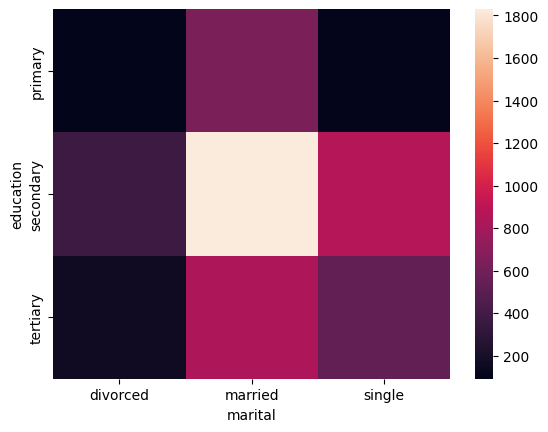

In [225]:
deposit_no = df[df.deposit=='no']
table = pd.pivot_table(deposit_no, index='education', columns='marital', values='deposit', aggfunc='count')
heatmap = sns.heatmap(data=table)

По данным сводным таблицам видно, что в обоих группах (хотят и не хотят открывать депозит), что самая многочисленная категория клиентов - это люди с семьей с средним образованием.

## Часть 3: преобразование данных

### Задание 1

In [226]:
# преобразуем уровни образования
lab_enc = LabelEncoder()
df['education'] = lab_enc.fit_transform(df['education'])
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,50-60,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,50-60,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,40-50,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,50-60,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,50-60,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [227]:
# сумма получившихся значений для признака education
df['education'].sum()

11995

In [229]:
# тоже самое делаем для признака age
lab_enc = LabelEncoder()
df['age'] = lab_enc.fit_transform(df['age'])

### Задание 2

In [230]:
lb = preprocessing.LabelBinarizer()
df['deposit'] = lb.fit_transform(df['deposit'])
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,2,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,2,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,1,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,2,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,2,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [231]:
# Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit. Ответ округлен до трёх знаков после точки-разделителя.
print(round(df['deposit'].std(), 3))

0.499


In [232]:
# преобразуем все остальные бинарные признаки
def transform_lb(data):
    data['default'] = lb.fit_transform(data['default'])
    data['housing'] = lb.fit_transform(data['housing'])
    data['loan'] = lb.fit_transform(data['loan'])
    return data

df = transform_lb(df)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,2,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1
1,2,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1
2,1,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1
3,2,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1
4,2,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1


In [233]:
# Вычислили среднее арифметическое для каждой из получившихся переменных, сложили три результата и округлили его до трёх знаков после точки-разделителя.
print(round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3))

0.635


### Задание 3

In [234]:
dummy_var = ['job', 'marital', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=dummy_var)

In [235]:
df

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,2,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,2,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,1,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,2,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,2,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,0,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,0,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,1,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


Таким образом, стало 45 признаков, признаки 'job', 'marital', 'contact', 'month', 'poutcome' были преобразованы.

### Задание 4

<AxesSubplot:>

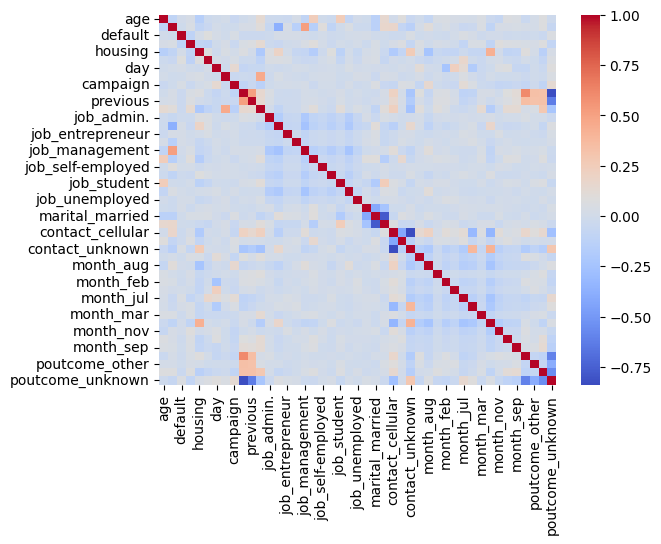

In [236]:
# Визуализируем матрицу корреляции
sns.heatmap(df.corr(), cmap='coolwarm')

Расставим признаки, в наибольшей степени коррелирующие с целевой переменной, по убыванию силы линейной взаимосвязи, а также построим визуализацию.

In [237]:
corr = df.corr()

new_corr = corr['deposit'].reset_index()
sort_corr = new_corr.sort_values('deposit', ascending=False)
sort_corr.head()

,index,deposit
11,deposit,1.000000
7,duration,0.457818
43,poutcome_success,0.288491
26,contact_cellular,0.223944
9,pdays,0.147917


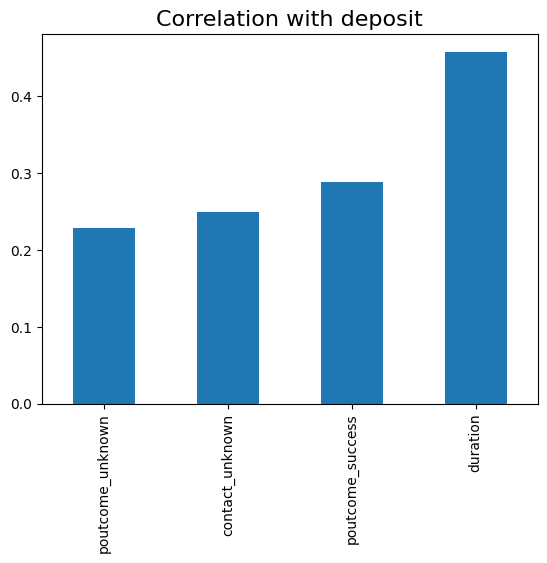

In [238]:
corr['deposit'].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.bar()
plt.title('Correlation with deposit', fontsize=16)
plt.show()

### Задание 5

In [248]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [240]:
# Определим размер тестовой выборки
X_test.shape

(3335, 44)

In [282]:
# Среднее значение целевой переменной на тестовой выборке
round(y_test.mean(), 2)

0.46

### Задание 6

С помощью SelectKBest отберем 15 наиболее подходящих признаков

In [283]:
from itertools import compress
skb = SelectKBest(f_classif, k=15).fit(X_train, y_train)
mask = skb.get_support()
name_col = X_train.columns.values

list(compress(name_col, mask))

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [284]:
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 7

Нормализуем данные с помощью minmaxsxaler

In [285]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [286]:
round(X_test_scaled[:, 0].mean(), 2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

Обучим логистическую регрессию и рассчитаем метрики качества

In [287]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(solver='sag', random_state=42, max_iter=1000)

log_model.fit(X_train_scaled, y_train)
y_train_predict = log_model.predict(X_train_scaled)
print(classification_report(y_train, y_train_predict))

y_test_predict = log_model.predict(X_test_scaled)
print(classification_report(y_test, y_test_predict))

print("Test accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predict)))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335

Test accuracy: 0.80


### Задание 2

Обучим решающие деревья, настроим максимальную глубину дерева, чтобы не было переобучения

In [289]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=6
)

dt.fit(X_train_scaled, y_train)
y_train_predict = dt.predict(X_train_scaled)

print("Train accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predict)))

y_test_predict = dt.predict(X_test_scaled)

print("Test accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predict)))

Train accuracy: 0.82
Test accuracy: 0.81


### Задание 3

Подберем оптимальные параметры с помощью gridsearch

In [291]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth':[3, 5, 7], 'min_samples_split':[2, 5, 7, 10]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, cv=3, scoring=('f1'), return_train_score=True)
model_cv.fit(X_train_scaled, y_train)

print('Наилучшие значения параметров: {}'.format(model_cv.best_params_))

y_test_pred = model_cv.predict(X_test_scaled)

print("Test f1_score: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 2}
Test f1_score: 0.80


In [292]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

Обучим на ваших данных случайный лес и получим метрики accuracy и  recall

In [294]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,
                            criterion='gini',
                            min_samples_leaf=5,
                            max_depth=10,
                            random_state=42)

# Обучаем на тренировочных данных
rf.fit(X_train_scaled, y_train)
# Выводим значение метрики
y_train_pred = rf.predict(X_train_scaled)
print("Train accuracy: {:.2f}".format(accuracy_score(y_train, y_train_pred)))

y_test_pred = rf.predict(X_test_scaled)
print("Test accuracy: {:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Test recall: {:.2f}".format(metrics.recall_score(y_test, y_test_pred)))

Train accuracy: 0.86
Test accuracy: 0.83
Test recall: 0.83


### Задание 2

In [295]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

params = {'n_estimators':300,
          'random_state':42,
          'max_depth':5,
          'learning_rate':0.05,
          'min_samples_leaf':5
          }

gbr = ensemble.GradientBoostingClassifier(**params)
gbr.fit(X_train_scaled, y_train)

y_train_pred = gbr.predict(X_train_scaled)
print("Train f1_score: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = gbr.predict(X_test_scaled)
print("Test f1_score: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))

Train f1_score: 0.88
Test f1_score: 0.82


### Задание3

Применим стекинг 

In [296]:
estimators = [
    ('dt', tree.DecisionTreeClassifier(
      criterion='entropy',
      random_state=42,
      max_depth=6,
      min_samples_leaf=5
      )
    ),
    ('log_model', linear_model.LogisticRegression(
      solver='sag', 
      random_state=42, 
      max_iter=1000
      )
    ),
    ('gbr', ensemble.GradientBoostingClassifier(
      n_estimators=300,
      random_state=42,
      max_depth=5,
      learning_rate=0.05,
      min_samples_leaf=5
      )
    )
]

stack = ensemble.StackingClassifier(
  estimators,
  final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

y_train_pred = stack.predict(X_train_scaled)
y_test_pred = stack.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 4

Feature: 0, Score 0.05976
Feature: 1, Score 0.04658
Feature: 2, Score 0.50199
Feature: 3, Score 0.01710
Feature: 4, Score 0.05565
Feature: 5, Score 0.00890
Feature: 6, Score 0.04210
Feature: 7, Score 0.00460
Feature: 8, Score 0.07376
Feature: 9, Score 0.02614
Feature: 10, Score 0.01451
Feature: 11, Score 0.01882
Feature: 12, Score 0.01343
Feature: 13, Score 0.11626
Feature: 14, Score 0.00039


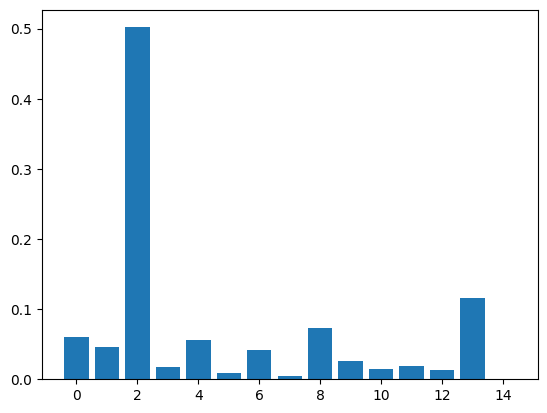

In [297]:
importance = gbr.feature_importances_
for i, v in enumerate(importance):
    print('Feature: %0d, Score %.5f' % (i, v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Задание 5

Реализуем оптимизацию гиперпараметров с помощью Optuna

In [299]:
import optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

study = optuna.create_study()

study.optimize(optuna_rf, n_trials=20)
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)

print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2022-10-24 21:32:14,062] A new study created in memory with name: no-name-2c9574b7-e0a4-47fd-a4cf-8f63325905d3
[I 2022-10-24 21:32:14,709] Trial 0 finished with value: 0.8619181505779444 and parameters: {'n_estimators': 169, 'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8619181505779444.
[I 2022-10-24 21:32:15,187] Trial 1 finished with value: 0.8914447770600283 and parameters: {'n_estimators': 109, 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8619181505779444.
[I 2022-10-24 21:32:15,838] Trial 2 finished with value: 0.876017532874139 and parameters: {'n_estimators': 152, 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8619181505779444.
[I 2022-10-24 21:32:16,203] Trial 3 finished with value: 0.8497019140257296 and parameters: {'n_estimators': 104, 'max_depth': 19, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8497019140257296.
[I 2022-10-24 21:32:16,870] Trial 4 finished with value: 0.8905589478628464

accuracy на тестовом наборе: 0.821
f1_score на тестовом наборе: 0.810
